In [1]:
import numpy as np
import pandas as pd
from scipy.cluster.vq import whiten, kmeans, vq, kmeans2
import random as rd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

%matplotlib inline

In [ ]:
# rd.seed(42)

In [ ]:
x = rd.sample(range(0, 2500), k=1000)
y = rd.sample(range(0, 3000), k=1000)
data = np.array(list(zip(x,y)))
points = pd.DataFrame({"x":x, "y":y})
# in the future, remove overlapping points

In [ ]:
sns.scatterplot(x = "x", y = "y", data = points, s=10)

In [ ]:
k_means = KMeans(n_clusters=7, random_state=0).fit(data)
labels = k_means.labels_

In [ ]:
points["id"] = labels

In [ ]:
# clustered points
sns.scatterplot(x = "x", y = "y", hue = "id", data = points, palette="Set2", s=10)

In [ ]:
points2 = points.copy()
k_means2 = MiniBatchKMeans(n_clusters=7, random_state=0, batch_size=6, max_iter=10).fit(data)
# k_means2 = KMeans(init='random', n_clusters=7, random_state=0).fit(data)
labels2 = k_means2.labels_
points2["id"] = labels2
sns.scatterplot(x = "x", y = "y", hue = "id", data = points2, palette="Set2", s=10)

In [ ]:
diff_points = points2.copy()

In [ ]:
points.value_counts(subset='id').values

In [ ]:
points2.value_counts(subset='id').values

# Using pair-wise distance for k-means clustering points
**Not applicable to general-case dataset, because sklearn.KMeans methods are used, but dataset's clusters are not KMeans.**  
1.To pair the cluster centers per closest one. Cluster centers are generated using centroids.  
2.Change to other cluster criteria to be used with `pair-wise distance`.

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances_argmin

centers1 = k_means.cluster_centers_
centers2 = k_means2.cluster_centers_

In [ ]:
order = pairwise_distances_argmin(centers1, centers2)
centers2 = centers2[order]

In [ ]:
temp_labels = pairwise_distances_argmin(data, centers1)
temp_labels2 = pairwise_distances_argmin(data, centers2)

In [ ]:
different = temp_labels2 == 100

In [ ]:
identical = temp_labels == temp_labels2
different = np.logical_not(identical)

In [ ]:
plt.plot(data[identical, 0], data[identical, 1], "w", markerfacecolor="#bbbbbb", marker=".")
plt.plot(data[different, 0], data[different, 1], "w", markerfacecolor="m", marker=".")

In [ ]:
points2["new_id"] = temp_labels2
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.scatterplot(x = "x", y = "y", hue = "id", data = points, palette="Set2", ax=ax[0], legend=False, s=10)
sns.scatterplot(x = "x", y = "y", hue = "new_id", data = points2, palette="Set2", ax=ax[1], legend=False, s=10)

## Work with the 2 datasets
**Only given `(x,y)` and `id` as inputs.**  
For now, `points` and `points2` shouldn't change anymore.   

**Problem**: when a dataset is clustered, the ID can be different. Since the plotting techniques plot the colors based on the IDs, the coloring for the “same” cluster will also change from dataset-to-dataset, ie. from day-to-day. To determine how to assign the same ID to the “same” cluster helps assign the “same” color to the same cluster, hence making following visualization easier.
If I have access to the clustering technique: assign the ID numbers explicitly. But I don’t have access to the clustering algorithm, hence need to determine the “same” clusters using (x,y) coordinates.

**Method**: use the 1st dataset as a benchmark, use properties of cluster, determine the centroids for all clusters in 1st, and same for all clusters in 2nd. Compare each centroid in 2nd to every centroid in 1st, pick the closest one, then change 2nd那个centroid对应的cluster里所有点的ID to be 1st中最近centroid的cluster的ID.

In [ ]:
print(points.info())
print(points2.info())

In [ ]:
points["coor"] = points.apply(lambda r : [r[0], r[1]], axis=1)
points2["coor"] = points2.apply(lambda r : [r[0], r[1]], axis=1)
print(points.head(3))
print(points2.head(3))

In [ ]:
cp_points = pd.DataFrame(points.groupby("id")["coor"].apply(list).reset_index(name='all_coor'))
cp_points2 = pd.DataFrame(points2.groupby("id")["coor"].apply(list).reset_index(name='all_coor'))

In [ ]:
print(cp_points.info())
print(cp_points2.info())

#### Using centroids as the criterion.

In [ ]:
def centroid(ls):
    arr = np.array(ls)
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return [(sum_x/length).round(2), (sum_y/length).round(2)]
cp_points["centroid"] = cp_points.all_coor.apply(lambda r : centroid(r))
cp_points2["centroid"] = cp_points2.all_coor.apply(lambda r : centroid(r))

In [ ]:
print(cp_points.head(3))
print(cp_points2.head(3))

In [ ]:
order = pairwise_distances_argmin(list(cp_points2["centroid"]), list(cp_points["centroid"]))
new_id = cp_points["centroid"][order].index
cp_points2["id"] = new_id

In [ ]:
temp = cp_points2.explode("all_coor")[["id", "all_coor"]]
temp["x"] = temp.all_coor.apply(lambda x : x[0])
temp["y"] = temp.all_coor.apply(lambda x : x[1])
new_points2 = temp
new_points2.head()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.scatterplot(x = "x", y = "y", hue = "id", data = points, palette="Set2", ax=ax[0], legend=False, s=10)
sns.scatterplot(x = "x", y = "y", hue = "id", data = new_points2, palette="Set2", ax=ax[1], s=10)
sns.scatterplot(x = list(zip(*cp_points["centroid"]))[0], 
                y = list(zip(*cp_points["centroid"]))[1], ax=ax[0], marker="D")
sns.scatterplot(x = list(zip(*cp_points2["centroid"]))[0], 
                y = list(zip(*cp_points2["centroid"]))[1], ax=ax[1], marker="D")

In [ ]:
points2 = new_points2.copy()
points2.rename(columns = {"all_coor":"coor"}, inplace=True)

#### C-shaped cluster, no additional clusters. (still working with 7 groups)

In [ ]:
points3 = points2.copy() # should've been diff_points.copy()

In [ ]:
keep_id_one = lambda x,y : x >= -1/250*(y-500)**2 + 2000

In [ ]:
def change_id(row):
    if row["id"] != 1:
        return row["id"]
    elif keep_id_one(row["x"], row["y"]):
        return 1
    else:
        return 5

In [ ]:
points3["id"] = points3.apply(lambda row : change_id(row), axis=1)

In [ ]:
cp_points3 = pd.DataFrame(points3.groupby("id")["coor"].apply(list).reset_index(name='all_coor'))
cp_points3["centroid"] = cp_points3.all_coor.apply(lambda r : centroid(r))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.scatterplot(x = "x", y = "y", hue = "id", data = points, palette="Set2", ax=ax[0], legend=False, s=10).set(title="Dataset: points")
sns.scatterplot(x = "x", y = "y", hue = "id", data = points3, palette="Set2", ax=ax[1], legend=False, s=10).set(title="Dataset: points3")
sns.scatterplot(x = list(zip(*cp_points["centroid"]))[0], 
                y = list(zip(*cp_points["centroid"]))[1], ax=ax[0], marker="D", color="orange")
sns.scatterplot(x = list(zip(*cp_points["centroid"]))[0], 
                y = list(zip(*cp_points["centroid"]))[1], ax=ax[1], marker="s", color="green")
sns.scatterplot(x = list(zip(*cp_points3["centroid"]))[0], 
                y = list(zip(*cp_points3["centroid"]))[1], ax=ax[1], marker="D", color="orange")

#### Change the centered cluster into c-shape

#### Additional cluster

In [ ]:
points4 = diff_points.copy()
keep_id_four = lambda x,y : y > x-1300
def change_id(row):
    if row["id"] != 4:
        return row["id"]
    elif keep_id_four(row["x"], row["y"]):
        return 4
    else:
        return 7

In [ ]:
points4["id"] = points4.apply(lambda row : change_id(row), axis=1)
sns.scatterplot(x = "x", y = "y", hue = "id", data = points4, palette="Set2", s=10).set(title="Dataset: points4")

In [ ]:
cp_points4 = pd.DataFrame(points4.groupby("id")["coor"].apply(list).reset_index(name='all_coor'))
cp_points4["centroid"] = cp_points4.all_coor.apply(lambda r : centroid(r))
order = pairwise_distances_argmin(list(cp_points4["centroid"]), list(cp_points["centroid"]))
order

In [ ]:
cp_points["centroid"][order]
new_id = cp_points["centroid"][order].index
cp_points4["id"] = new_id

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.scatterplot(x = "x", y = "y", hue = "id", data = points, palette="Set2", ax=ax[0], legend=False, s=10).set(title="Dataset: points")
sns.scatterplot(x = "x", y = "y", hue = "id", data = points4, palette="Set2", ax=ax[1], legend=False, s=10).set(title="Dataset: points4")
sns.scatterplot(x = list(zip(*cp_points["centroid"]))[0], 
                y = list(zip(*cp_points["centroid"]))[1], ax=ax[0], marker="D", color="orange")
sns.scatterplot(x = list(zip(*cp_points["centroid"]))[0], 
                y = list(zip(*cp_points["centroid"]))[1], ax=ax[1], marker="s", color="green")
sns.scatterplot(x = list(zip(*cp_points4["centroid"]))[0], 
                y = list(zip(*cp_points4["centroid"]))[1], ax=ax[1], marker="D", color="orange")

# Using CT_Clusters.csv dataset

## A. Some EDA and preliminary data visualization

In [2]:
df_clusters = pd.read_csv("./CT_Clusters.csv")
print(df_clusters.info())
print(df_clusters.describe())
df_clusters.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12828 entries, 0 to 12827
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cluster_membership  12828 non-null  int64  
 1   lat_round           12828 non-null  float64
 2   lon_round           12828 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 300.8 KB
None
       cluster_membership     lat_round     lon_round
count        12828.000000  12828.000000  12828.000000
mean             9.625896     41.515125    -72.870864
std              5.705690      0.257943      0.446928
min              1.000000     41.002000    -73.697000
25%              5.000000     41.310000    -73.221000
50%              9.000000     41.515000    -72.892000
75%             14.000000     41.736000    -72.601000
max             20.000000     42.042000    -71.799000


,cluster_membership,lat_round,lon_round
0,10,41.571,-73.018
1,19,41.814,-72.259
2,19,41.814,-72.259
3,19,41.814,-72.259
4,10,41.594,-73.051


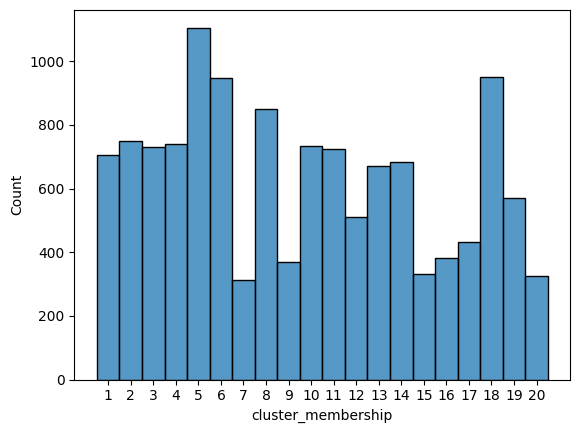

In [3]:
sns.histplot(x = "cluster_membership", data = df_clusters, discrete = True)
plt.xticks(range(min(df_clusters["cluster_membership"]), max(df_clusters["cluster_membership"]) + 1))
plt.show()

In [4]:
'''
The max number of unique(qualitative) coloring schemes in matplotlib/seaborn is 12.
Hence need to create our own.
'''
coloring = sns.color_palette("Spectral", n_colors=20)
# coloring = sns.color_palette("icefire", n_colors=20)
light_coloring = sns.light_palette("purple", n_colors=20)
dark_coloring = sns.dark_palette("purple", n_colors=20)

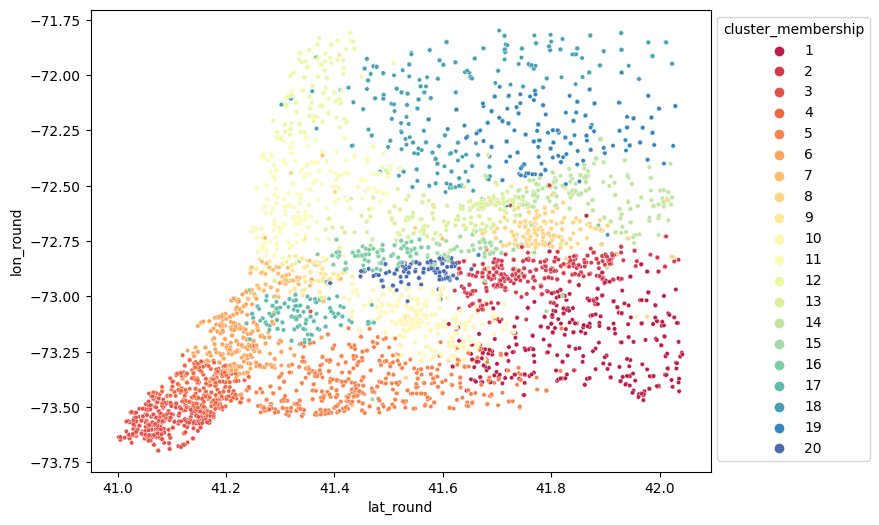

In [5]:
plt.figure(figsize=(8,6))
ax = sns.scatterplot(x = "lat_round", y = "lon_round", data = df_clusters, hue = "cluster_membership",
                     palette = coloring, s=10)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## B. Plot the centroids. 

In [6]:
def centroid(ls):
    arr = np.array(ls)
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return [(sum_x/length).round(2), (sum_y/length).round(2)]

In [7]:
def all_coor(df):
    return list(zip(df["lat_round"], df["lon_round"]))

In [8]:
# An easier way to aggregate all points coordinates in a group, using Groupby.apply()
df_centroids = pd.DataFrame(df_clusters.groupby("cluster_membership").apply(all_coor).reset_index(name = "coordinates"))
df_centroids.set_index("cluster_membership", inplace = True)
df_centroids["centroid"] = df_centroids["coordinates"].apply(lambda r : centroid(r))
df_centroids.head()

,coordinates,centroid
cluster_membership,,
1,"[(42.009, -73.181), (42.009, -73.181), (42.009...","[41.85, -73.17]"
2,"[(41.893, -72.765), (41.639, -72.841), (41.855...","[41.77, -72.89]"
3,"[(41.02, -73.626), (41.054, -73.531), (41.054,...","[41.08, -73.57]"
4,"[(41.163, -73.373), (41.163, -73.373), (41.163...","[41.15, -73.41]"
5,"[(41.682, -73.487), (41.682, -73.487), (41.682...","[41.45, -73.4]"


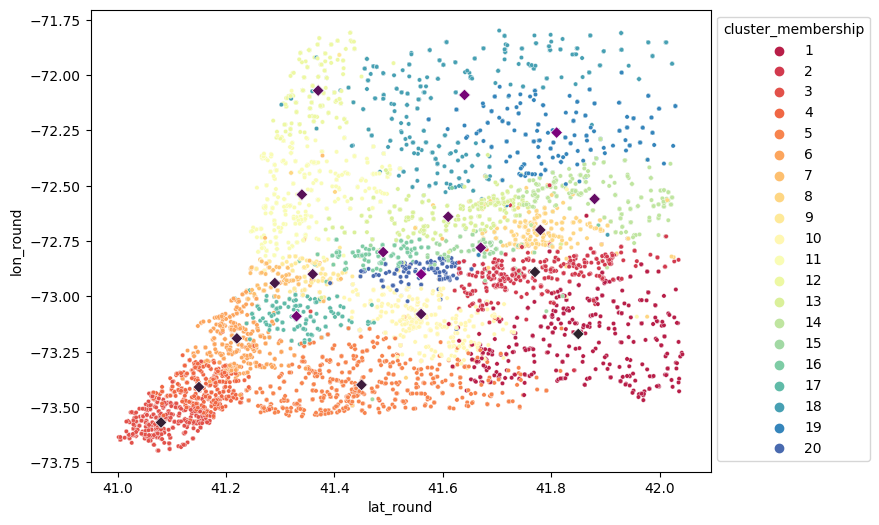

In [9]:
plt.figure(figsize=(8,6))
ax = sns.scatterplot(x = "lat_round", y = "lon_round", data = df_clusters, hue = "cluster_membership", 
                     palette=coloring, s=10)
sns.scatterplot(x = list(zip(*df_centroids["centroid"]))[0], 
                y = list(zip(*df_centroids["centroid"]))[1], 
                marker="D", legend=False, hue=df_centroids.index, palette=dark_coloring)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## C. Work with 15-20 membership assignments (using K-means or other ways)
1. Use jittering to change the distances so that K-means change the memberships. 
2. Then calculate the centroids. 
3. Use pairwise-distance to detect "same" id numbers. (check if this works)

### C.1 Generate 15 k-means id's, 1 original id's, 1 minibatch-k id's
<span style="color:red">**The following is used to generate `new_Clusters.csv`, hence don't run it repeatedly.**</span>

 **Data prep, create k-means generator.**

In [10]:
df_new = df_clusters.copy()
coord = np.array(list(zip(df_new["lat_round"], df_new["lon_round"])))
n_clusters = df_new["cluster_membership"].nunique()

kmeans = KMeans(n_clusters=n_clusters, random_state=0)
df_new["col_1"] = kmeans.fit(coord).labels_
kmeansmb = MiniBatchKMeans(n_clusters=n_clusters, random_state=0, batch_size=6, max_iter=10)
df_new["col_16"] = kmeansmb.fit(coord).labels_

Text(0.5, 1.0, 'Day_16')

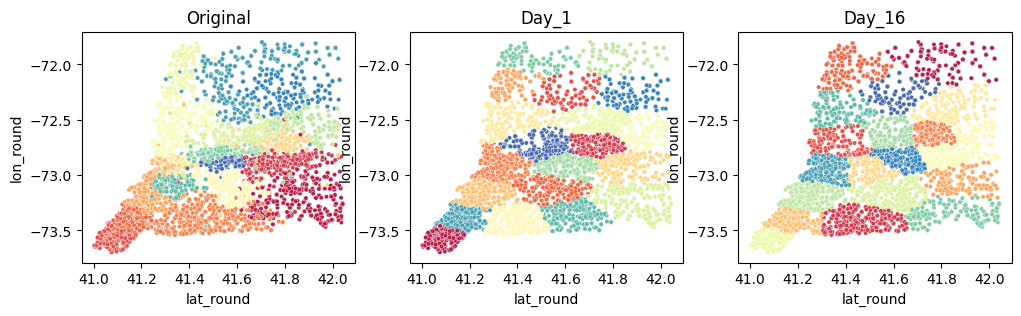

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.scatterplot(x = "lat_round", y = "lon_round", data = df_new, hue = "cluster_membership", 
                palette = coloring, s=10, legend=False, ax=ax[0])
sns.scatterplot(x = "lat_round", y = "lon_round", data = df_new, hue = "col_1", 
                palette = coloring, s=10, legend=False, ax=ax[1])
sns.scatterplot(x = "lat_round", y = "lon_round", data = df_new, hue = "col_16", 
                palette = coloring, s=10, legend=False, ax=ax[2])
ax[0].set_title("Original")
ax[1].set_title("Day_1")
ax[2].set_title("Day_16")

**Create jittering function. Can choose to jitter x, y, or both. Can also choose the jittering variance in a normal distribution.**

In [12]:
from numpy.random import RandomState

def jitter(coor, sigmax, sigmay, seed=12345):
    """
    Jitter a single point using Gaussian distribution.
    Input:
        coor - List[Float, Float]: coordinate of the point
        sigmax - Float: standard deviation for x, non-negative. If negative, return original x.
        sigmay - Float: standard deviation for y, non-negative. If negative, return original y.
        seed - Int: choose the seed for random generator of normal distribution. Can ensure reproducibility.
    Output:
        [new_x, new_y] - List[Float, Float]: new coordinate for the input point.
    """
    prng = RandomState(seed)
    x, y = coor[0], coor[1]
    new_x, new_y = x, y
    
    if sigmax >= 0:
        new_x = prng.normal(x, scale=sigmax)
    if sigmay >= 0:
        new_y = prng.normal(y, scale=sigmay)
    return [new_x, new_y]

In [13]:
def new_membership(coord):
    """
    Input: coord - np.array[[Float, Float], ...]
    Output: new_coord - np.array[[Float, Float], ...]
    """
    new_coord = list()
    for c in coord:
        temp = jitter(c, sigmax=rd.uniform(-0.5,0.5), sigmay=rd.uniform(-0.5,0.5))
        new_coord.append(temp)
    return np.array(new_coord)

In [20]:
new_coord = new_membership(coord)
df_new["col_2"] = kmeans.fit(new_coord).labels_

Text(0.5, 1.0, 'Day_2')

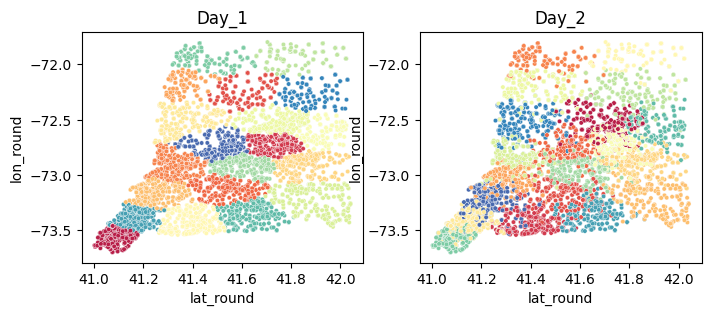

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
sns.scatterplot(x = "lat_round", y = "lon_round", data = df_new, hue = "col_1", 
                palette = coloring, s=10, legend=False, ax=ax[0])
sns.scatterplot(x = "lat_round", y = "lon_round", data = df_new, hue = "col_2", 
                palette = coloring, s=10, legend=False, ax=ax[1])
ax[0].set_title("Day_1")
ax[1].set_title("Day_2")

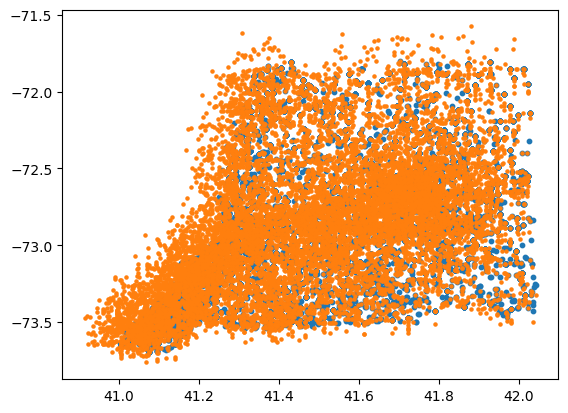

In [16]:
plt.scatter(coord[:,0], coord[:,1], s=10)
plt.scatter(new_coord[:,0], new_coord[:,1], s=5)

**Apply to generate 13 more assignments.**

In [22]:
cur_coord = new_coord
for i in range(13):
    col = "col_" + str(i+3)
    new = new_membership(cur_coord)
    df_new[col] = kmeans.fit(new).labels_
    cur_coord = new
    print(f'{col} finished generating.')

col_3 finished generating.
col_4 finished generating.
col_5 finished generating.
col_6 finished generating.
col_7 finished generating.
col_8 finished generating.
col_9 finished generating.
col_10 finished generating.
col_11 finished generating.
col_12 finished generating.
col_13 finished generating.
col_14 finished generating.
col_15 finished generating.


In [33]:
temp = df_new.pop("col_16")
df_new["col_16"] = temp
df_new.head()

,cluster_membership,lat_round,lon_round,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16
0,10,41.571,-73.018,14,14,1,17,6,18,5,18,11,4,10,2,13,1,1,7
1,19,41.814,-72.259,18,13,17,6,7,15,13,2,10,16,16,18,14,18,2,8
2,19,41.814,-72.259,18,13,17,6,3,7,13,0,0,1,6,15,11,17,17,8
3,19,41.814,-72.259,18,13,17,6,7,15,2,8,9,1,6,15,11,17,17,8
4,10,41.594,-73.051,3,2,11,4,8,1,19,6,19,4,10,2,13,1,11,12


In [34]:
df_new.to_csv('new_Clusters.csv', index=False)

In [ ]:
!less new_Clusters.csv

cluster_membership,lat_round,lon_round,col_1,col_2,col_3,col_4,col_5,col_6,col_7 ,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16
10,41.571,-73.018,14,14,1,17,6,18,5,18,11,4,10,2,13,1,1,7
19,41.814,-72.259,18,13,17,6,7,15,13,2,10,16,16,18,14,18,2,8
19,41.814,-72.259,18,13,17,6,3,7,13,0,0,1,6,15,11,17,17,8
19,41.814,-72.259,18,13,17,6,7,15,2,8,9,1,6,15,11,17,17,8
10,41.594,-73.051,3,2,11,4,8,1,19,6,19,4,10,2,13,1,11,12
3,41.02,-73.626,0,15,6,5,11,16,11,14,15,3,9,12,6,15,7,11
7,41.334,-72.945,4,5,13,10,6,4,0,4,18,18,8,17,15,19,18,17
7,41.334,-72.945,4,5,13,10,15,19,7,19,1,9,14,19,1,8,8,17
8,41.893,-72.765,10,7,7,12,17,9,9,3,2,19,19,13,18,13,0,10
8,41.893,-72.765,10,16,16,9,4,14,17,17,6,15,13,7,9,14,4,10
2,41.893,-72.765,10,16,16,9,4,2,10,17,6,13,7,7,14,0,14,10
14,41.788,-72.601,11,0,14,2,1,15,2,0,0,1,6,5,11,17,14,4
14,41.788,-72.601,11,16,4,16,1,2,10,17,10,13,13,18,14,18,14,4
8,41.788,-72.601,11,10,14,2,4,2,10,17,6,15,13,16,4,10,10,4
14,41.788,-72.601,11,0,17,6,7,7,13,2,10,

### C.2 Calculate the centroids, using pairwise-min-distance to see if clusters match each other

**Plot all 17 clusters, from `new_Clusters.csv`.**

In [38]:
df_new = pd.read_csv("./new_Clusters.csv")
print(df_new.info())
print(df_new.describe())
df_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12828 entries, 0 to 12827
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cluster_membership  12828 non-null  int64  
 1   lat_round           12828 non-null  float64
 2   lon_round           12828 non-null  float64
 3   col_1               12828 non-null  int64  
 4   col_2               12828 non-null  int64  
 5   col_3               12828 non-null  int64  
 6   col_4               12828 non-null  int64  
 7   col_5               12828 non-null  int64  
 8   col_6               12828 non-null  int64  
 9   col_7               12828 non-null  int64  
 10  col_8               12828 non-null  int64  
 11  col_9               12828 non-null  int64  
 12  col_10              12828 non-null  int64  
 13  col_11              12828 non-null  int64  
 14  col_12              12828 non-null  int64  
 15  col_13              12828 non-null  int64  
 16  col_

,cluster_membership,lat_round,lon_round,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16
0,10,41.571,-73.018,14,14,1,17,6,18,5,18,11,4,10,2,13,1,1,7
1,19,41.814,-72.259,18,13,17,6,7,15,13,2,10,16,16,18,14,18,2,8
2,19,41.814,-72.259,18,13,17,6,3,7,13,0,0,1,6,15,11,17,17,8
3,19,41.814,-72.259,18,13,17,6,7,15,2,8,9,1,6,15,11,17,17,8
4,10,41.594,-73.051,3,2,11,4,8,1,19,6,19,4,10,2,13,1,11,12


## D. Animation for the changes

Check this: https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot

In [ ]:
import matplotlib.animation as ani

animator = ani.FuncAnimation(fig, chartfunc, interval = 100)

In [ ]:
color = ['red', 'green', 'blue', 'orange']
fig = plt.figure()
plt.xticks(rotation=45, ha="right", rotation_mode="anchor") #rotate the x-axis values
plt.subplots_adjust(bottom = 0.2, top = 0.9) #ensuring the dates (on the x-axis) fit in the screen
plt.ylabel('No of Deaths')
plt.xlabel('Dates')

In [ ]:
def buildmebarchart(i=int):
    plt.legend(df1.columns)
    p = plt.plot(df1[:i].index, df1[:i].values) #note it only returns the dataset, up to the point i
    for i in range(0,4):
        p[i].set_color(color[i]) #set the colour of each curve
import matplotlib.animation as ani
animator = ani.FuncAnimation(fig, buildmebarchart, interval = 100)
plt.show()